# ASTR 596: FDS - The Midterm

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [2]:
exec(open('cepheids.py').read())
ceph = Cepheids('../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()

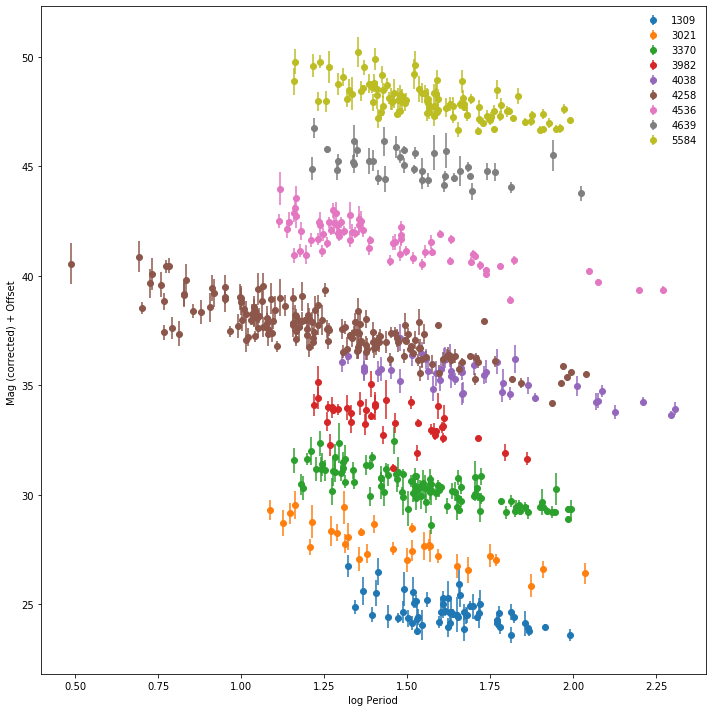

In [3]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(3*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


---

### The sum of two independent normally distributed random variables is also normally sidtributed, and the variance of the sum is just the sum of the variance of the two variables:

### $$\sigma_{tot,i,j}^2 = \sigma_{obs,i,j}^2 + \sigma_{int}^2
$$



### The likelihood can be expressed as:

### $$ P = \exp\left(-\dfrac{\chi^2}{2}\right) = \exp\left( -\dfrac{1}{2}\sum_i \sum_j \dfrac{(m_{obs}-m_{W,i,j})^2}{\sigma_{obs,i,j}^2 + \sigma_{int}^2} \right)
$$

### where $m_{W,i,j} = (\mu_{0,i} - \mu_{0,4258}) + zp_{w,4258} + b_W \log P_{i,j} $

### The loglikelihood can be expressed as:

### $$ logP = -\dfrac{\chi^2}{2} =  -\dfrac{1}{2}\sum_i \sum_j \dfrac{(m_{obs}-m_{W,i,j})^2}{\sigma_{obs,i,j}^2 + \sigma_{int}^2}
$$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

---

### The parameters $b_W$ has to be negative as the longer peirod Cepheids tend to be brighter.  We can have a tophat prior for $b_W$ between -5 to 0.

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn; seaborn.set() #nice plot formatting
import pandas as pd
import corner
from collections import namedtuple

import emcee

In [135]:
# RUN THIS


# parameters to be fit, dmu = mu_i - mu_4258
params = namedtuple('params', ['dmu13','dmu30','dmu33','dmu39', 'dmu40', 'dmu45','dmu46',\
                               'dmu55', 'bw', 'zp' ])
sig_int = 0.1

theta_lim = params(dmu45=(-5,8),
                   dmu46=(-5,8),
                   dmu33=(-5,8),
                   dmu39=(-5,8),
                   dmu30=(-5,8),
                   dmu13=(-5,8),
                   dmu55=(-5,8),
                   dmu40=(-5,8),
                   bw=(-5,0),
                   zp=(0,50)
                  )

theta_min, theta_max = map(np.array, zip(*theta_lim))

# return the calculated magnitube based on theta
def magnitude(i, logP, theta):
    
    # when i==5 set dmu=0 since hosts[5] is 4258
    if i<=4:
        dmu = theta[i]
    elif i==5:
        dmu = 0
    else:
        dmu = theta[i-1]
    bw,zp = theta[-2:]
    
#     print(dmu,bw,zp)
    
    return dmu + zp + bw *logP
    

def log_prior(theta):
    if np.any(theta < theta_min) or np.any(theta > theta_max):
        return -np.inf # log(0)
    
    return 0

def log_likelihood(theta):
    lnlike = 0
    
    for i, ID in enumerate(hosts):
        ceph.select(ID)
        mobs = ceph.mobs
        logP = ceph.logP
        sigma_obs = ceph.sigma
        sig_tot2  = sigma_obs**2 + sig_int**2
        
        m_model = magnitude(i, logP, theta)
        
        lnlike += np.sum( (mobs - m_model) ** 2 / sig_tot2)

    
    
    return -0.5 * lnlike


def log_posterior(theta):
    ln_prior = log_prior(theta)
    if np.isinf(ln_prior):
        return ln_prior
    else:
        return log_likelihood(theta)
    
def make_starting_guess():

    return params(dmu13=2, dmu30=2,dmu33=2,dmu39=2,
                  dmu40=2,
                  dmu45=2,
                  dmu46=2,
                  dmu55=2,
                   bw=-3,
                   zp=30
                  )

In [64]:
theta_guess = make_starting_guess()
# theta_guess

ndim = len(theta_guess)  # number of parameters in the model
nwalkers = 40  # number of MCMC walkers

# start with a tight distribution of theta around the initial guess
rng = np.random.RandomState(42)
starting_guesses = theta_guess * (1 + 0.2 * rng.randn(nwalkers, ndim))

# RUN MCMC

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=None)

In [65]:
# Run burn-in phase
nburn  = 400

print("Running burn-in... ")
sampler.run_mcmc(starting_guesses, nburn, progress=True)

# burned_guesses = sampler.chain[:,-1,:]
# sampler.reset()
print("Done.")

  0%|          | 0/400 [00:00<?, ?it/s]/Users/frank/miniconda3/envs/fds/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 6/400 [00:00<00:07, 52.40it/s]

Running burn-in... 


100%|██████████| 400/400 [00:07<00:00, 54.80it/s]

Done.


In [66]:
nsteps = 1000
# Run actual chains
print("Running chains... ")
sampler.run_mcmc(None, nsteps, progress=True)

print("Mean acceptance fraction: ",np.mean(sampler.acceptance_fraction))

  1%|          | 6/1000 [00:00<00:18, 52.56it/s]

Running chains... 


100%|██████████| 1000/1000 [00:17<00:00, 55.69it/s]

Mean acceptance fraction:  0.4211607142857142


## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


In [75]:
def plot_chains(sampler, nburn):
    fig, ax = plt.subplots(10, figsize=(10, 15), sharex=True)
    for i in range(10):
        ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i].set_ylabel(params._fields[i])
        ax[i].grid()
        
        ax[i].axvspan(0,nburn,color='red',alpha=0.3,label='burn-in')
        ax[i].legend()
        
    

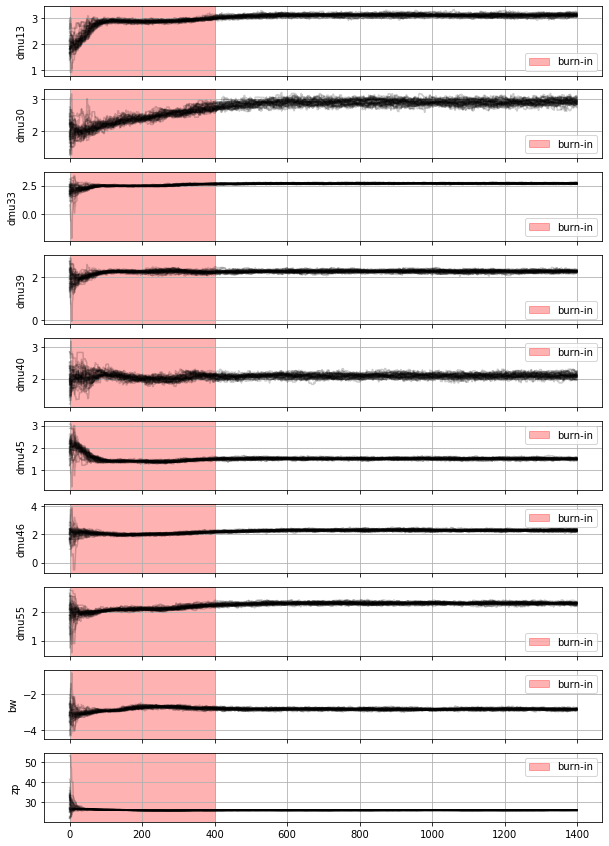

In [76]:
plot_chains(sampler, nburn)

In [68]:
param_bestfit = np.median(sampler.chain[:,nburn:], axis=(0,1))
print('Bestfit parameters:\n', param_bestfit)
print('LnL:',log_posterior(param_bestfit))

Bestfit parameters:
 [ 3.10594652  2.88219848  2.68683698  2.26335042  2.08574093  1.51009929
  2.27531726  2.28864558 -2.84590901 26.09022698]
LnL: -930.1669275683012


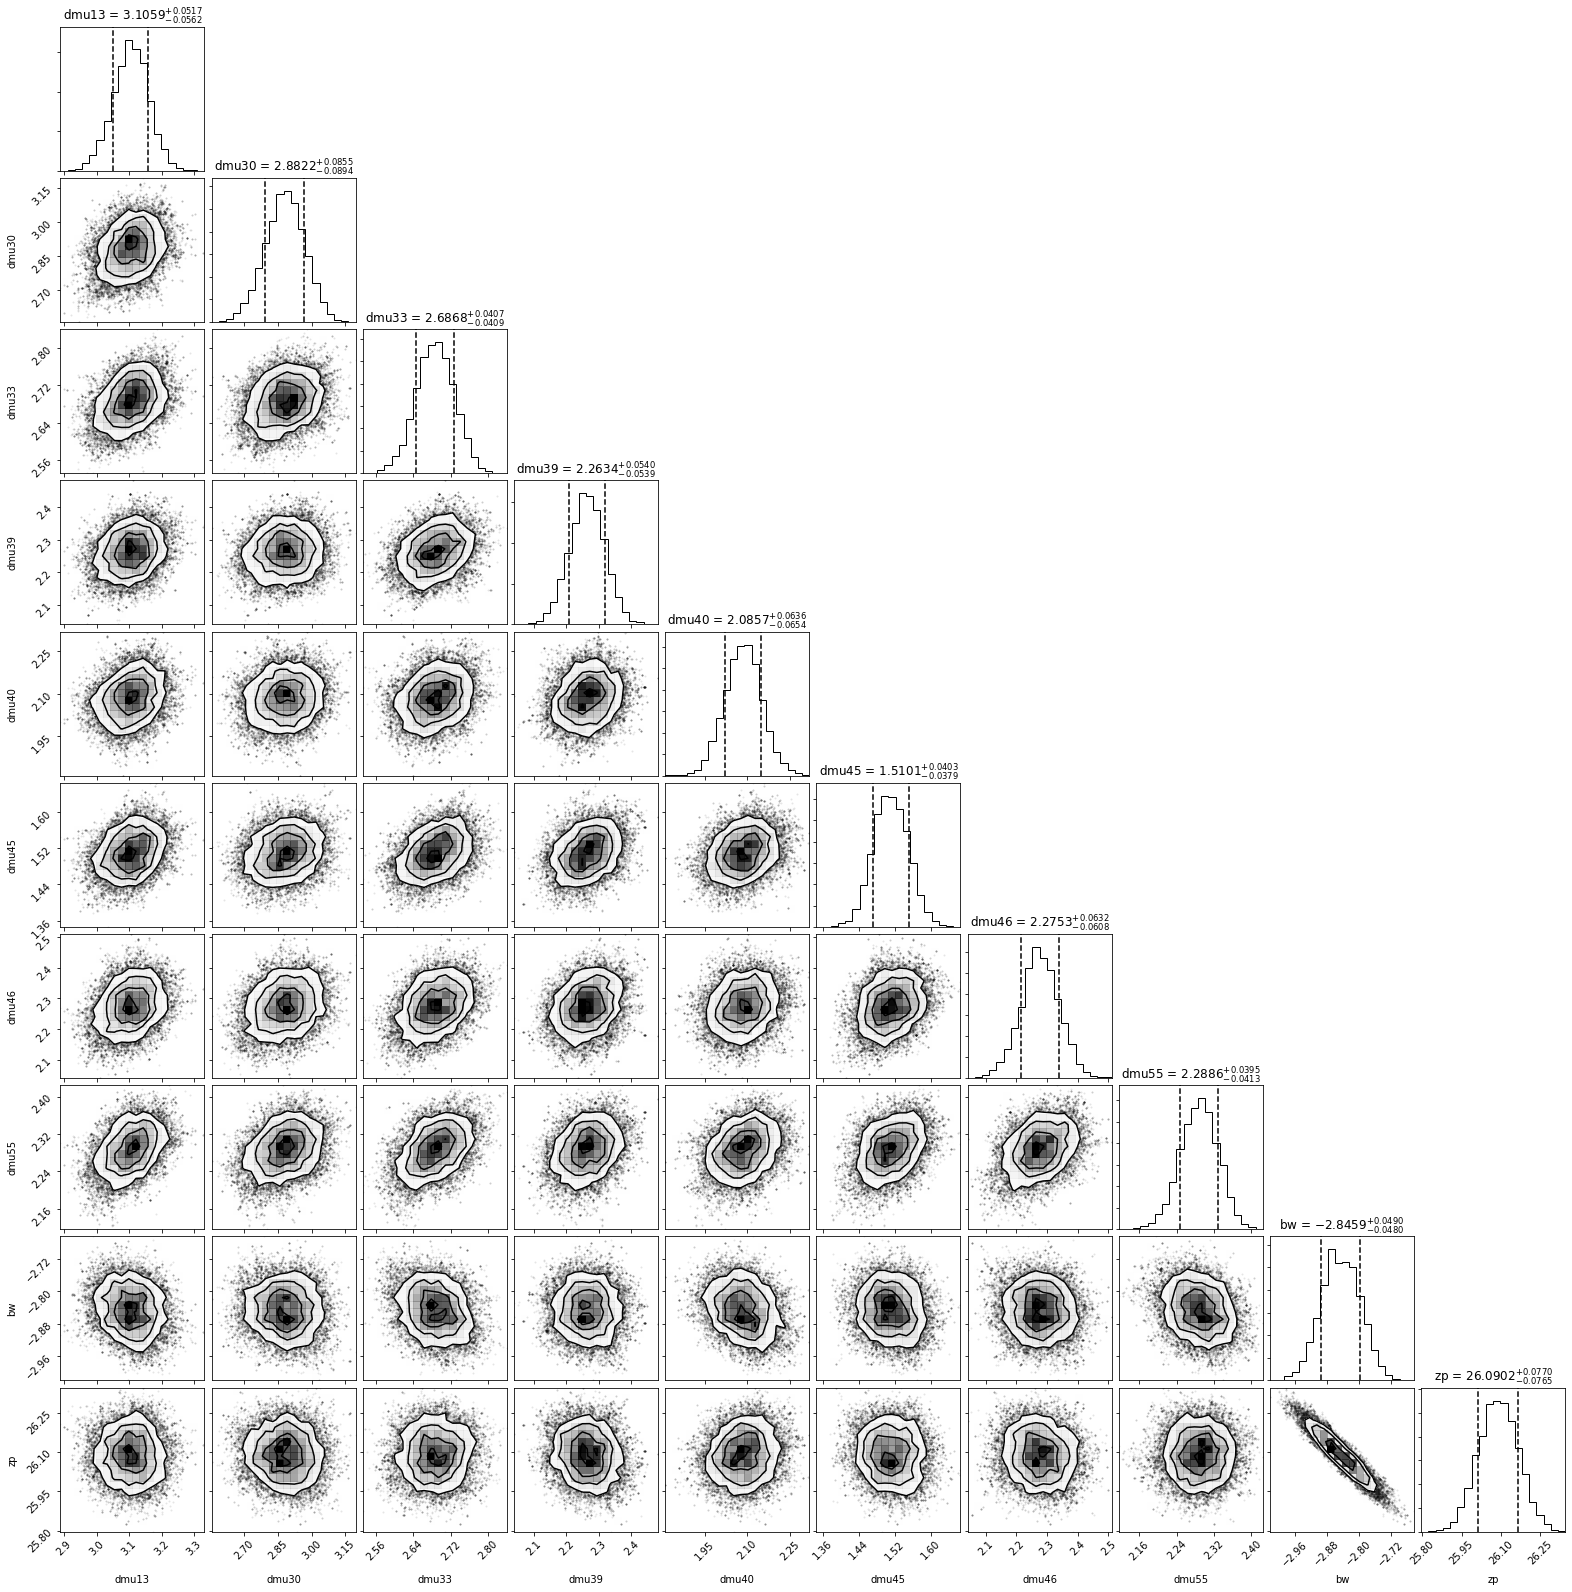

In [69]:
samples = sampler.get_chain(discard=nburn, flat=True,)
figure = corner.corner(samples, labels=params._fields,\
                       quantiles=(0.16, 0.84), title_fmt='.4f', \
                       show_titles=True,)

## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

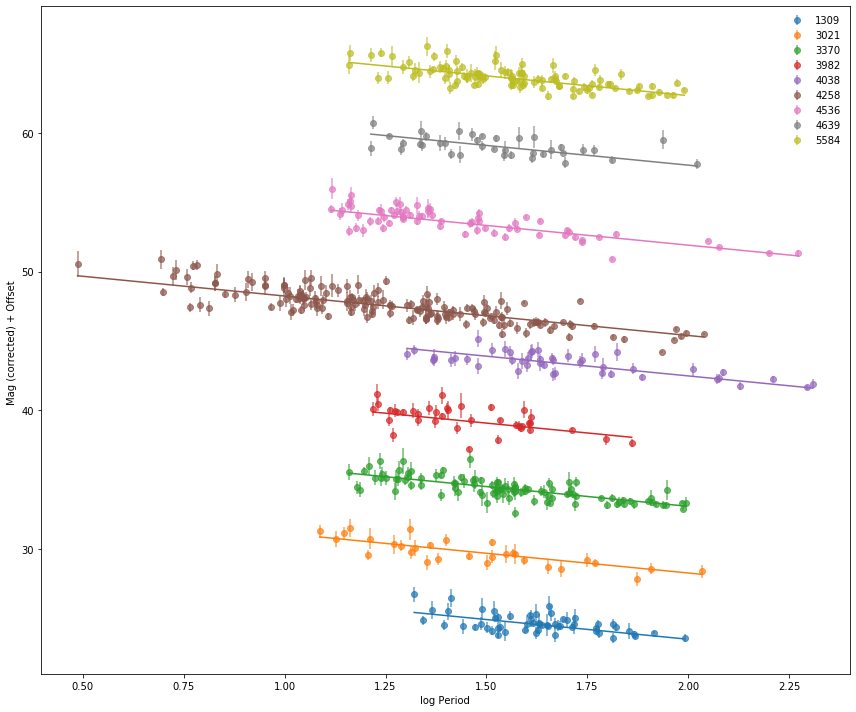

In [70]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    logpP_fit = np.linspace(logP.min(), logP.max(), 1000)
    
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, color='C%i'%i, linestyle='None', marker='o', alpha=0.7,\
                label=ID)
    ax.plot(logpP_fit, (5*i)+magnitude(i, logpP_fit, param_bestfit))
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()


## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011


In [37]:
hosts

array(['1309', '3021', '3370', '3982', '4038', '4258', '4536', '4639',
       '5584'], dtype='<U21')

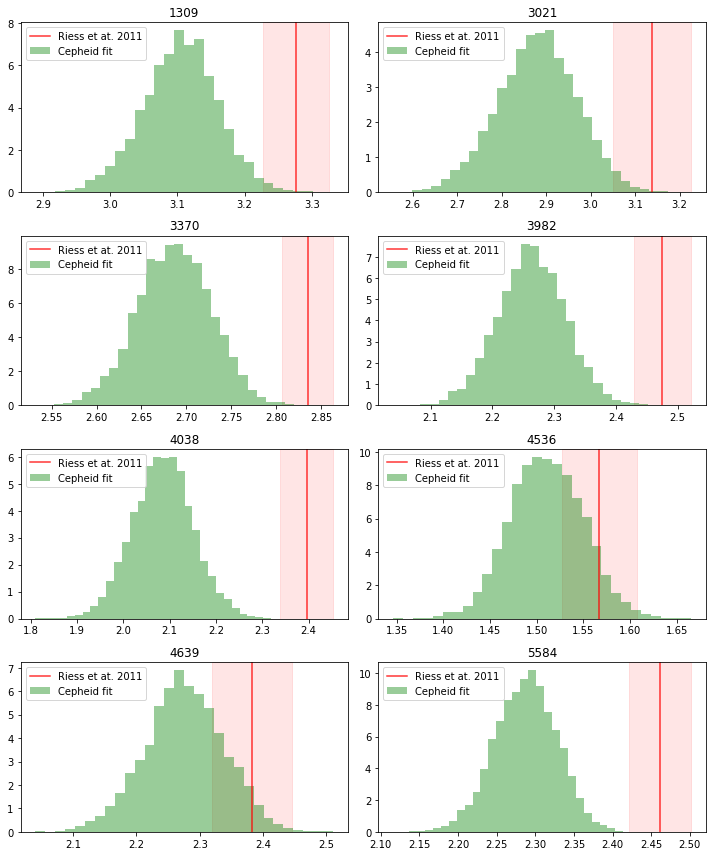

In [85]:
# Riess et al. 2011 parameters

dmu_Riess = np.array([[ 3.276, 0.0491], [ 3.138 ,0.0870],[2.835 ,0.0284],[2.475,0.0460],\
                      [2.396 , 0.0567], [1.567,0.0404],  [2.383, 0.0630],[2.461,0.0401]])

fig,axes = plt.subplots(4,2, figsize=(10,12))

for i, ax in enumerate(axes.flat):
    ax.axvline(x=dmu_Riess[i,0], color='red', alpha=0.8, label='Riess et at. 2011')
    ax.axvspan(dmu_Riess[i,0]-dmu_Riess[i,1],dmu_Riess[i,0]+dmu_Riess[i,1], color='red', alpha=0.1)  
    ax.hist(samples[:,i], 30, density=1, facecolor='green', alpha=0.4,\
            label = 'Cepheid fit')
    ax.legend()
    ax.set_title(hosts[np.arange(len(hosts))!=5][i])
    
plt.tight_layout()



# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

---

### The equation 4 can be expressed as:
$$\log H_{0}=\frac{\left(m_{v, 4258}^{0}-\mu_{0,4258}\right)+5 a_{v}+25}{5} = \frac{\left(m_{v, i}^{0}-\left(\mu_{0, i}-\mu_{0,4258}\right)-\mu_{0,4258}\right)+5 a_{v}+25}{5} = \frac{
m_{v, i}^{0}-\mu_{0, i}+5 a_{v}+25}{5}$$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [87]:
mv_plus_5av = np.array([16.768,16.699,16.545,15.953,15.901,15.147,16.040,16.274])

d_4258 = 7.6e6 # in pc

mu_4258 = 5*np.log10(d_4258)-5

In [116]:
logH0 = (mv_plus_5av +25 -samples[:,:8] -mu_4258)/5

H0 = 10**logH0.flatten()

The median of sampled Hubble constant is:74.72 km s^-1 Mpc^-1
The Hubble constant in Riess et al. 2011 is:73.80 km s^-1 Mpc^-1


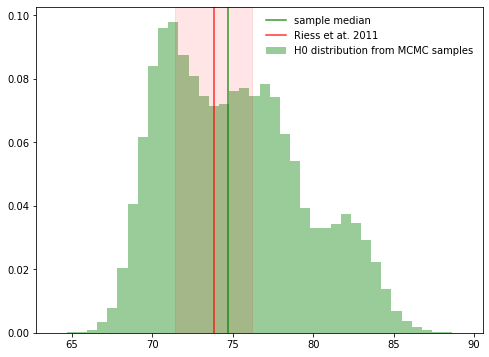

In [134]:

fig,ax = plt.subplots(figsize=(8,6))

H0_Riess = np.array([73.8,2.4])

plt.hist(H0, bins=40, density=1, facecolor='green', alpha=0.4,\
         label = 'H0 distribution from MCMC samples')

plt.axvline(x=np.median(H0), color='green', alpha=0.8, label='sample median')
plt.axvline(x=H0_Riess[0], color='red', alpha=0.8, label='Riess et at. 2011')
plt.axvspan(H0_Riess[0]-H0_Riess[1],H0_Riess[0]+H0_Riess[1], color='red', alpha=0.1) 


plt.legend(frameon=0)

print(r"The median of sampled Hubble constant is:%.2f km s^-1 Mpc^-1"%np.median(H0))
print(r"The Hubble constant in Riess et al. 2011 is:%.2f km s^-1 Mpc^-1"%H0_Riess[0])